# Validation of multivaraite distributions: HPD vs multi-PIT
We here analyze, on a non-conditional 3D gaussian, the:
- sensitivity of HPD vs. marginal PIT-uniformity : rotating covariance and bias
- how to test mutual independance (correlation coefficients)
- interpretability of the multi-PIT

In [3]:
# import libraries
import torch
import torch.distributions as D
import torch.nn.functional as F

from scipy.stats import norm, uniform
from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nde.train import train_nflows
from nde.flows import construct_maf, count_parameters
from plot import PP_plot_1D, plot_2d_pdf_contours, PP_vals
from valdiags.graphical_valdiags import confidence_region_null

from valdiags.hpd_coverage_old import highest_density, highest_density_level
from valdiags.multi_local_test import compute_test_statistic

import os


## 3D gaussian distribution

Target data: $\mathbf{\theta}=(\theta_1,\theta_2, \theta_3) \sim f_{\theta}$.

Target distribution: 3D gaussian $f_{\theta} = \mathcal{N}(\mu,\Sigma)$ where $\mu = [\mu_1, \mu_2, \mu_3]$ and 
$\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho_{1,2} \sigma_1 \sigma_2 & \rho_{1,3} \sigma_1 \sigma_3\\ \rho_{1,2} \sigma_1 \sigma_2 & \sigma_{2}^2 & \rho_{2,3} \sigma_2 \sigma_3 \\ \rho_{1,3} \sigma_1 \sigma_3 & \rho_{2,3} \sigma_2 \sigma_3 & \sigma_{3}^2 \end{pmatrix}$.

We also define a *false* distribution, where we rotate the covariance matrix around the 3rd data-dimension ($\theta_3$-axis) by an angle $\psi \in [0, \pi/2]$, to investigate whether our diagnostics (multiPIT) cn capture this mismatch between distributions (and compare it to HDR):

$$ \Sigma_{false} = R(\psi)\Sigma R(\psi)^T \quad \text{with} \quad R(\psi) = \begin{pmatrix} \cos(\psi) & -\sin(\psi) & 0 \\ \sin(\psi) & \cos(\psi) & 0 \\ 0 & 0 & 1 \end{pmatrix}.$$ 

### Data 

#### Define Data Distributions 

In [4]:
# Parameters of the distribution
mu_1 = 0
mu_2 = 0
mu_3 = 0
sigma_1 = 1
sigma_2 = 1
sigma_3 = 1
rho_12 = 0.8
rho_13 = 0
rho_23 = 0

# True distribution: 3d gaussian
mean = np.array([mu_1, mu_2, mu_3])
covariance = np.array(
    [
        [sigma_1 ** 2, rho_12 * sigma_1 * sigma_2, rho_13 * sigma_1 * sigma_3],
        [rho_12 * sigma_1 * sigma_2, sigma_2 ** 2, rho_23 * sigma_2 * sigma_3],
        [rho_13 * sigma_1 * sigma_3, rho_23 * sigma_2 * sigma_3, sigma_2 ** 3],
    ]
)
multi_normal_dist = mvn(mean=mean, cov=covariance)

# "False distribution": 3d gaussian with same mean and rotated covariance matrix
# (by \psi around the 3rd dimension theta_3)

def rotation_matrix(angle):
    return np.array(
        [
            [np.cos(angle), -np.sin(angle), 0],
            [np.sin(angle), np.cos(angle), 0],
            [0, 0, 1],
        ]
    )

# rotate the covariance matrix 
angles = np.linspace(0, np.pi/2, 10)
covariance_false_list = [
    np.matmul(np.matmul(rotation_matrix(angle), covariance), rotation_matrix(angle).T)
    for angle in angles
]
false_mvns_list = [
    mvn(mean=mean, cov=cov_false) for cov_false in covariance_false_list
]



#### Generate Samples

$\mathbf{\theta} = (\theta_1, \theta_2, \theta_3) \sim f_{\theta} = \mathcal{N}(\mu, \Sigma)$: non-rotated distribution used to train the flow.

In [6]:
# Define target distribution
means = torch.FloatTensor(mean)  # Defined in previous section
covs = torch.FloatTensor(covariance)  # Defined in previous section
target_dist = D.multivariate_normal.MultivariateNormal(means, covs)

# Get train and test samples:
# - train samples are used to train the flow,
# - cal samples are used to train the regressors 
# - test samples are used to plot the pp-plots (evaluate the regressors).
train_size = 10_000
cal_size = 5_000
test_size = 1_000

filename = '../saved_experiments/Gaussian3D_multiPIT/datasets.pkl'
if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    theta_samples_train, theta_samples_cal, theta_samples_test = target_dist.sample((train_size,)), target_dist.sample((cal_size,)), target_dist.sample((test_size,))
    datasets = {'train': theta_samples_train, 'cal': theta_samples_cal, 'test':theta_samples_test}
    torch.save(datasets, filename)

print("NB training samples: ", datasets['train'].shape)
print("NB calibration samples: ", datasets['cal'].shape)
print("NB test samples: ", datasets['test'].shape)

NB training samples:  torch.Size([10000, 3])
NB calibration samples:  torch.Size([5000, 3])
NB test samples:  torch.Size([1000, 3])


### Train Normalizing Flow 
MAF with 4 layers and Reverse/Random Permutation, such that at the end the $i^{th}$ element of the flow transformation corresponds to the $i^{th}$ data coordinate.

In [7]:
# Define Flow: MAF (4 layer, 50 hidden features)
np.random.seed(14)
maf = construct_maf(
    datasets['train'],
    hidden_features=50,
    context_features=None,
    num_layers=4,
    random_permutation=True,
    standardize_transform=True,
)

# # look at permutations inside maf-transformation
# theta_new = datasets['train'][:1]
# print(theta_new)
# for i in range(3):
#     theta_new = maf._transform._transforms[1]._transforms[i*2](theta_new)[0]
#     print(theta_new)

In [9]:
import os
filename = f'../saved_experiments/Gaussian3D_multiPIT/maf_n_layers_4_n_{train_size}_random_perm.pkl'
if os.path.exists(filename):
    # Load Trained Flow
    maf = torch.load(filename)
else:
    # Train Flow
    best_val_loss, epochs = train_nflows(
        maf,
        datasets['train'],
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        epochs_until_converge=20,
    )
    torch.save(maf,filename)

## Eval on TRUE data distribution

### Marginals 
For each dimension $i$, we estimate $\mathbb{P}(\text{PIT}_i(\theta) \leq \alpha)$ empirically over a test set $\{\theta^j\}_{j=1}^N$, with $N = 1000$:
$$\mathbb{P}(\text{PIT}_i(\Theta) \leq \alpha) \approx \frac{1}{N}\sum_{j=1}^{N}\mathbf{I}_{\{\text{PIT}_i(\theta^j) \leq \alpha\}}$$

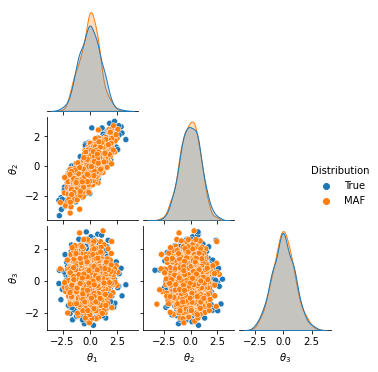

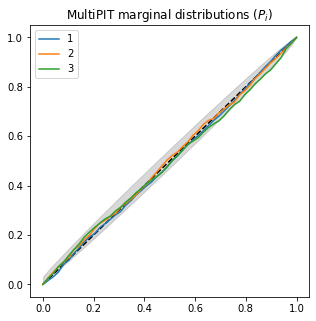

In [ ]:
# Plot distribution and PP-plots of the target distribution and the learned maf

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
colors = ['blue', 'orange']

samples_true = np.array(datasets['test'])
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples = maf.sample(test_size)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "MAF"

dfs = pd.concat([df_true, df_maf], ignore_index=True)

g = sns.pairplot(dfs, hue="Distribution", corner=True)
g.fig.set_size_inches(5,5)
plt.show()

# MAF transformation
P_1_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 0].detach().numpy())  # F_N(T^{-1}(theta)_1)
P_2_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 1].detach().numpy())  # F_N(T^{-1}(theta)_2)
P_3_maf = norm.cdf(maf._transform(datasets['test'])[0][:, 2].detach().numpy())  # F_N(T^{-1}(theta)_3)

plt.rcParams["figure.figsize"] = (5, 5)

# plot pp_plot variable 1
alphas = np.linspace(0.0001, 1, 50)
from scipy.stats import binom

confidence_region_null(alphas, conf_alpha=0.05/3) # bonferonni correction: global level at 0.05

# plot pp_plots variables 1,2,3
plt.plot(alphas,alphas, '--', color='black')
z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_1, label='1')
z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_2, label='2')
z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
plt.plot(alphas, z_maf_3, label='3')
plt.legend()
plt.title(r'MultiPIT marginal distributions ($P_i$)')
plt.show()



### Highest Density Region (HDR)

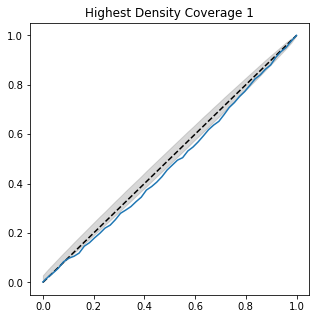

In [ ]:
# Highest Density Coverage 1: 
# Plot the probability of a true sample to be in the alpha-hdr of the estimator q:
# P_{theta_0}(q(theta_0) > hdr_level(q,alpha))

t_ = torch.linspace(-10, 10, 100)
T1, T2, T3 = torch.meshgrid(t_, t_, t_)
samples = torch.cat([T1.reshape(-1, 1), T2.reshape(-1, 1), T3.reshape(-1, 1)], dim=1)

pdf = maf._log_prob(samples, context=None).exp()
alphas = np.linspace(0.0001,0.9999,50)
coverage = []
for alpha in alphas:
    hdr_level = highest_density_level(pdf, alpha)
    coverage.append(np.array((torch.exp(maf.log_prob(datasets['test'])) > hdr_level)*1).mean())

confidence_region_null(alphas, conf_alpha=0.05)

plt.plot(alphas,alphas, '--', color='black')
plt.plot(alphas, coverage)
plt.title('Highest Density Coverage 1')
plt.show()

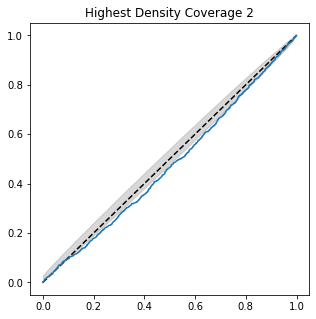

In [ ]:
# Highest Density Coverage 2:
# Same as before but via MC-estimation: 
# We compute the proportion of samples x ~ q having a higher estimated density than theta_0: 
# E_theta[I_{q(theta)>q(theta_0)}] 
    
# By computing this for a large number of theta_0, covering the space of the true distribution p(theta),
# we get the expected coverage (or levels) over all possible covergage levels in [0,1].

levels, coverages = highest_density(maf, datasets['test'])
confidence_region_null(alphas, conf_alpha=0.05) 
plt.plot(alphas,alphas, '--', color='black')
plt.plot(levels, coverages)
plt.title('Highest Density Coverage 2')
plt.show()

Both HDR-methods (1 and 2) are equivalent.

## Eval on FALSE data distribution

We keep the same trained MAF, but assume that the true data distribution is different than the samples the maf was trained on.

### Rotating the Covariance matrix

#### PP-plots 

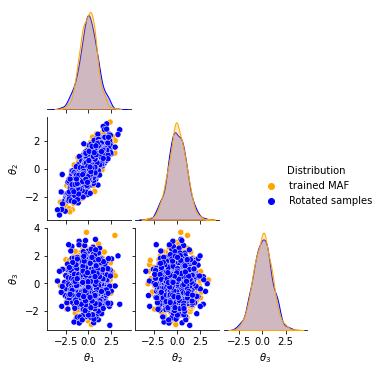

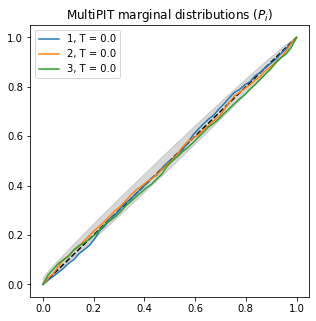

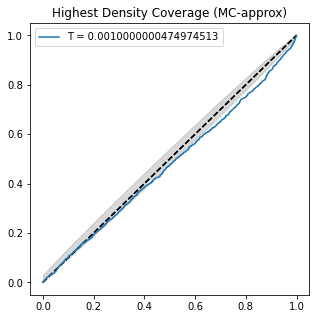

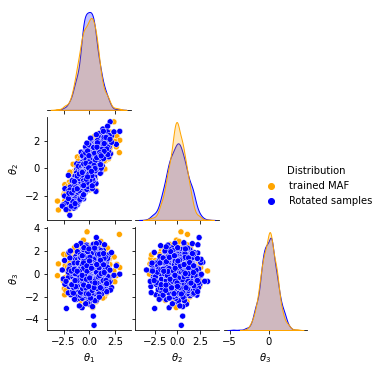

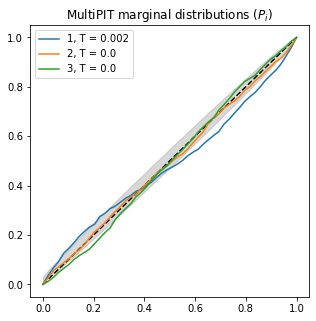

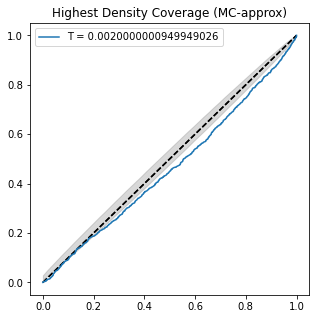

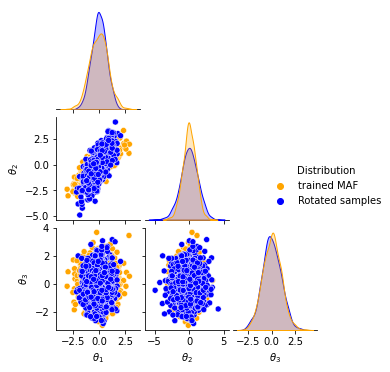

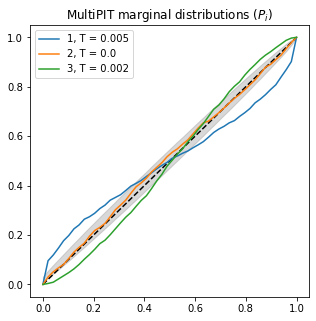

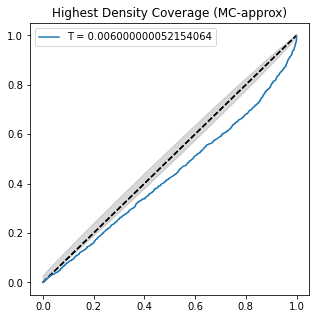

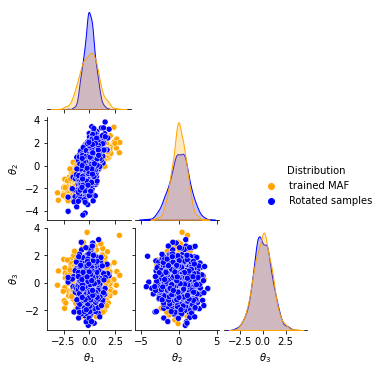

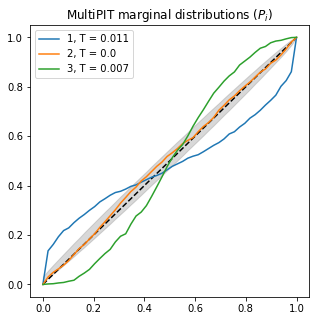

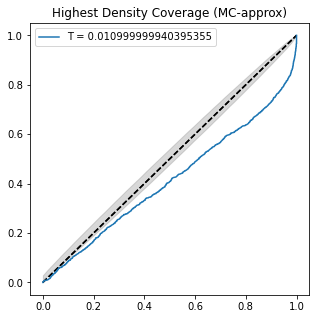

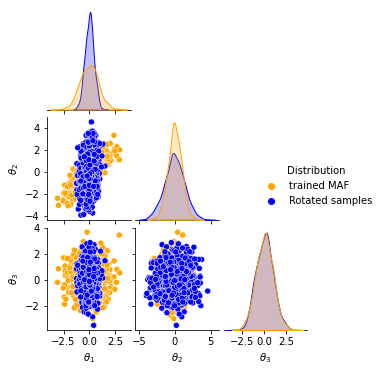

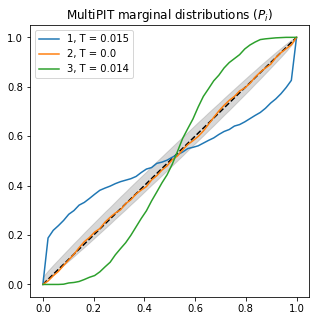

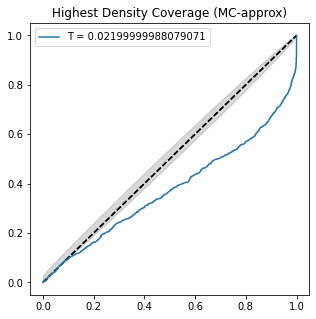

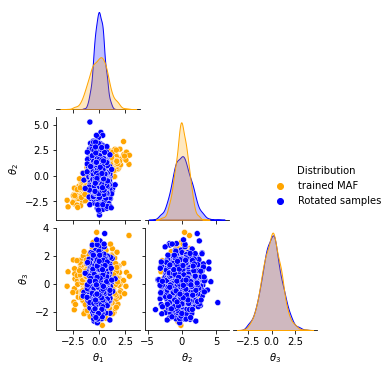

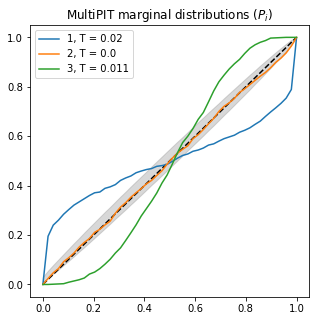

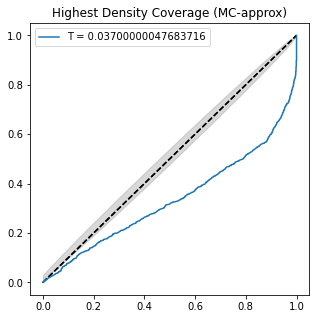

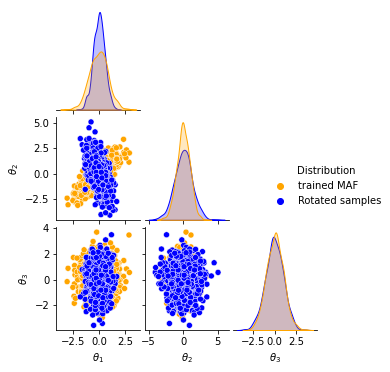

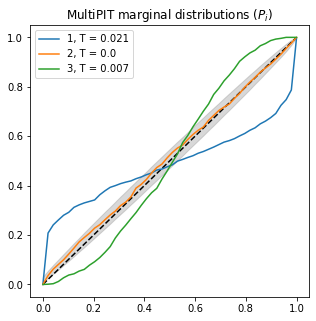

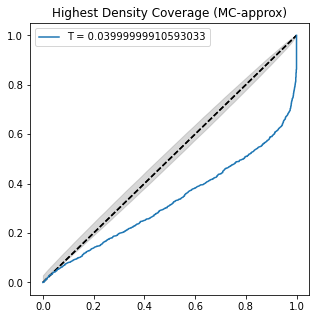

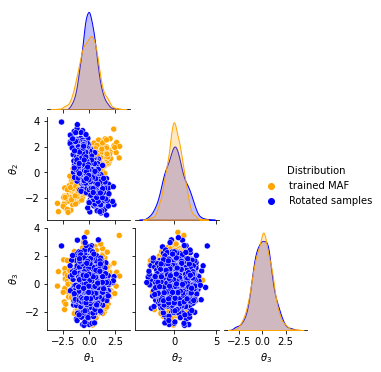

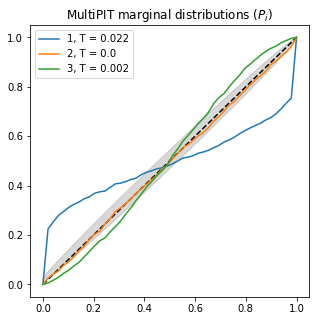

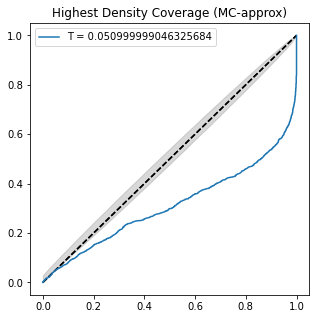

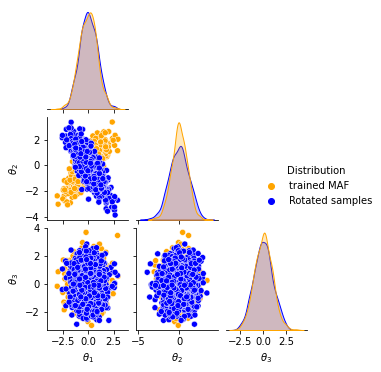

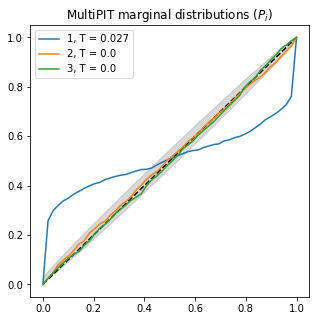

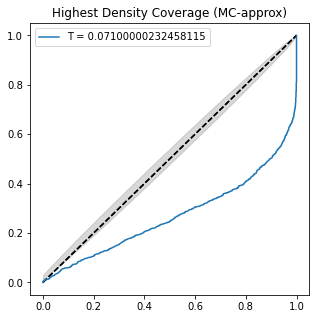

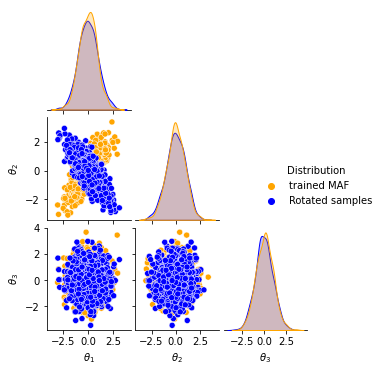

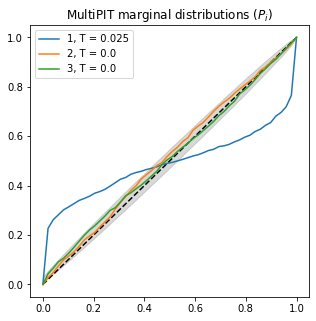

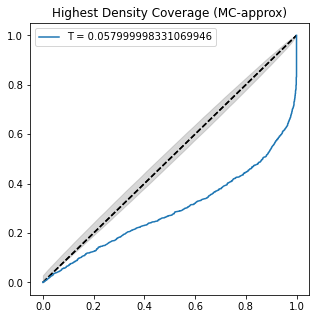

In [ ]:
# Plot distribution and pp-plots for the learned maf:
# trained on the original data, but evaluated in rotated samples.

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]

df_maf["Distribution"] = "trained MAF"

test_statistics_multiPIT = {}
test_statistics_multiPIT['dim_1'] = {}
test_statistics_multiPIT['dim_2'] = {}
test_statistics_multiPIT['dim_3'] = {}
test_statistics_hdr = {}
for i in range(len(angles)):
    samples_false_cal = false_mvns_list[i].rvs(cal_size)
    samples_false_test = false_mvns_list[i].rvs(test_size)

    df_false = pd.DataFrame(samples_false_test, columns=columns)
    df_false["Distribution"] = "Rotated samples"

    dfs = pd.concat([df_maf, df_false], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True, palette={"Rotated samples":"blue", "trained MAF": "orange"})
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()

    samples_false_test = torch.FloatTensor(samples_false_test)
    samples_false_cal = torch.FloatTensor(samples_false_cal)

    # MAF transformation on false samples
    P_1_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 0].detach().numpy())  # 1D
    P_2_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 1].detach().numpy())  # 1D
    P_3_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 2].detach().numpy())  # 1D

    # plot pp_plots variables 1,2,3
    alphas = np.linspace(0,1,50)
    confidence_region_null(alphas, conf_alpha = 0.05/3) # bonferonni correction: global level at 0.05
    plt.plot(alphas,alphas, '--', color='black')

    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_1'][i] = np.round(((z_maf_1 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_1, label=f'1, T = {test_statistics_multiPIT["dim_1"][i]}')
    z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_2'][i] = np.round(((z_maf_2 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_2, label=f'2, T = {test_statistics_multiPIT["dim_2"][i]}')
    z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_3'][i] = np.round(((z_maf_3 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_3, label=f'3, T = {test_statistics_multiPIT["dim_3"][i]}')
    plt.legend()
    plt.title(r'MultiPIT marginal distributions ($P_i$)')

    plt.show()

    # HDP
    
    # t_ = torch.linspace(-10, 10, 100)
    # T1, T2, T3 = torch.meshgrid(t_, t_, t_)
    # samples = torch.cat([T1.reshape(-1, 1), T2.reshape(-1, 1), T3.reshape(-1, 1)], dim=1)

    # pdf = maf._log_prob(samples, context=None).exp()
    
    # # alphas = np.linspace(0.001,1,50)
    # coverage = []
    # for alpha in alphas:
    #     hdr_level = highest_density_level(pdf, alpha)
    #     c = np.array((torch.exp(maf.log_prob(samples_false_test)) > hdr_level)*1).mean()
    #     coverage.append(c)
    # test_statistics_hdr[i] = np.round(((coverage - alphas) ** 2).sum() / len(alphas), 3)

    confidence_region_null(alphas, conf_alpha = 0.05) 
    plt.plot(alphas,alphas, '--', color='black')
    
    # plt.plot(alphas, coverage, label=f'T = {test_statistics_hdr[i]}')
    # plt.title('Highest Density Coverage')
    # plt.legend()
    # plt.show()

    levels, coverages = highest_density(maf, samples_false_test)
    test_statistics_hdr[i] = np.round((((coverages - levels) ** 2).sum() / len(levels)).item(), 3)
    plt.plot(levels,levels, '--', color='black')
    plt.plot(levels, coverages, label=f'T = {test_statistics_hdr[i]}')
    plt.title('Highest Density Coverage (MC-approx)')
    plt.legend()
    plt.show()

#### Test statistics

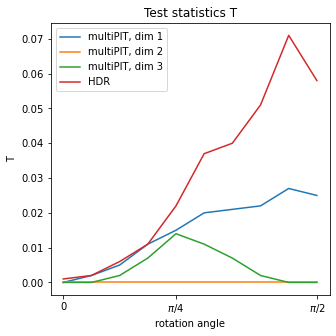

In [ ]:
pd.Series(test_statistics_multiPIT['dim_1']).plot(label='multiPIT, dim 1')
pd.Series(test_statistics_multiPIT['dim_2']).plot(label='multiPIT, dim 2')
pd.Series(test_statistics_multiPIT['dim_3']).plot(label='multiPIT, dim 3')
pd.Series(test_statistics_hdr).plot(label='HDR')
plt.title('Test statistics T')
plt.legend()
plt.xticks([0,4,9],labels=['0',r'$\pi/4$',r'$\pi/2$'])
plt.xlabel('rotation angle')
plt.ylabel('T')
plt.show()

In [ ]:
for i in range(1,10):
    test_statistics_hdr[i] = test_statistics_hdr[i].item()

#### Results: 
**Test statistics, comparison to HDR:**
- The test statistics reflect the introduced discreapancies (increasing for PIT covariates affected by the rotation)

    -->  why does dim 2 not change?
- HDR does not enable to see which dimension is affected.

**Estimation of the marginals, validating mutual independance:**
- We can evaluate the uniformity of the different PIT-covariates with the marginal pp-plots. But how can we evaluate the mutual independance? 

#### Independance of PIT-covariates
We visualize pair-wise independance between the PIT-covariates. 

In [90]:
# true distribution
pit_eval_true = {
        'Z_1':maf._transform(datasets['test'])[0][:, 0].detach().numpy(),
        'Z_2':maf._transform(datasets['test'])[0][:, 1].detach().numpy(),
        'Z_3':maf._transform(datasets['test'])[0][:, 2].detach().numpy(),
    }
df_true = pd.DataFrame(pit_eval_true)
corr_12_true = df_true.corr()['Z_1'][1]
corr_23_true = df_true.corr()['Z_2'][2]
corr_13_true = df_true.corr()['Z_1'][2]
df_true.corr()
eig_vals_true = np.linalg.eig(df_true.cov())[0]
print(eig_vals_true)
df_true.cov()

[0.94051589 1.07675389 1.17137512]


,Z_1,Z_2,Z_3
Z_1,0.957356,-0.047507,0.012403
Z_2,-0.047507,1.074576,-0.031927
Z_3,0.012403,-0.031927,1.156712


In [91]:
# rotated samples (false distribution)
corr_12 = []
corr_23 = []
corr_13 = []
for k in range(len(angles)):
    samples_false = torch.FloatTensor(false_mvns_list[k].rvs(cal_size))
    pit_eval = {
        'Z_1': maf._transform(samples_false)[0][:, 0].detach().numpy(),
        'Z_2': maf._transform(samples_false)[0][:, 1].detach().numpy(),
        'Z_3': maf._transform(samples_false)[0][:, 2].detach().numpy(),
    }
    df = pd.DataFrame(pit_eval)
    corr_12.append(df.corr()['Z_1'][1])
    corr_23.append(df.corr()['Z_2'][2])
    corr_13.append(df.corr()['Z_1'][2])


In [92]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_12_null = []
corr_23_null = []
corr_13_null = []
for t in range(n_trials):
    pit_eval_null = {
        'Z_1': norm().rvs(1000),
        'Z_2': norm().rvs(1000),
        'Z_3': norm().rvs(1000),
    }
    df_null = pd.DataFrame(pit_eval_null)
    corr_12_null.append(df_null.corr()['Z_1'][1])
    corr_23_null.append(df_null.corr()['Z_2'][2])
    corr_13_null.append(df_null.corr()['Z_1'][2])

##### Correlation Coefficient

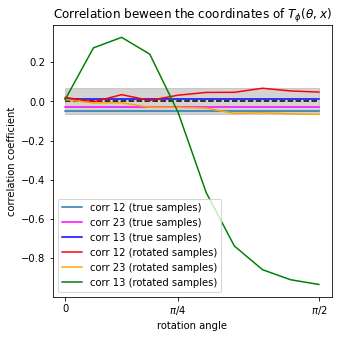

In [95]:
# PLOT
upp_lim = np.mean([np.quantile(corr_13_null, q=0.05/6), np.quantile(corr_12_null, q=0.05/2), np.quantile(corr_23_null, q=0.05/2)])
low_lim = np.mean([np.quantile(corr_13_null, q=1-0.05/6), np.quantile(corr_12_null, q=1-0.05/2), np.quantile(corr_23_null, q=1-0.05/2)])

mean = np.mean([np.mean(corr_13_null), np.mean(corr_12_null), np.mean(corr_23_null)])
plt.plot([mean]*len(angles), '--', color='black')
plt.fill_between(
        x=np.linspace(0, 9, len(angles)),
        y1=np.repeat(low_lim, len(angles)),
        y2=np.repeat(upp_lim, len(angles)),
        color="darkgrey",
        alpha=0.5,
    )

plt.plot([corr_12_true]*len(angles), label = 'corr 12 (true samples)')
plt.plot([corr_23_true]*len(angles), color = 'magenta', label = 'corr 23 (true samples)')
plt.plot([corr_13_true]*len(angles), color='blue', label='corr 13 (true samples)')
plt.plot(corr_12, label = 'corr 12 (rotated samples)', color='red')
plt.plot(corr_23, label = 'corr 23 (rotated samples)', color='orange')
plt.plot(corr_13, label = 'corr 13 (rotated samples)', color='green')
plt.legend()
plt.xticks([0,4,9],labels=['0',r'$\pi/4$',r'$\pi/2$'])
plt.xlabel('rotation angle')
plt.ylabel('correlation coefficient')
plt.title(r'Correlation beween the coordinates of $T_{\phi}(\theta,x)$')
plt.show()

This plot shows that rotating the covariance matrix in the samples affects the independance between the PIT-covariates. 

**Checking mutual independance on top of uniformity:**

Assuming that the uniformity test for the marginals pass, we can check for mutual independance by looking at the covariance matrix:

If the uniformity tests for the marginals pass, this means that each coviariate $\text{PIT}_i = F_{\mathcal{N}(0,1)}(T_{i,\phi}^{-1}(\Theta))$ is uniform, which means that each $T_{i,\phi}^{-1}(\Theta)$ is normally distributed.

Now mutually independance for normal random variables means that the correlation matrix is equal to the identity matrix. 
We can thus look at 
- the correlation coefficients and check if they are equal to zero. 

### Bias
MAF evaluated in samples from biased distribution (shifted mean)

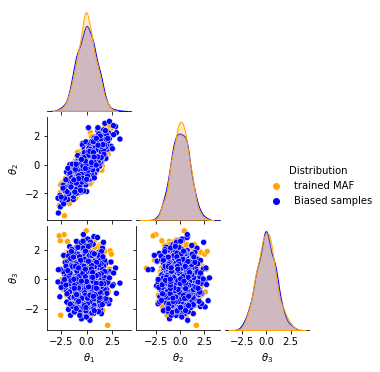

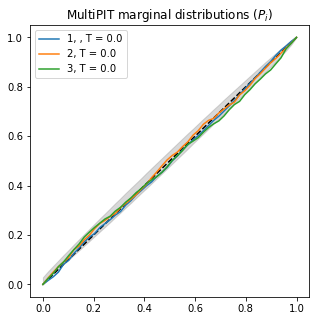

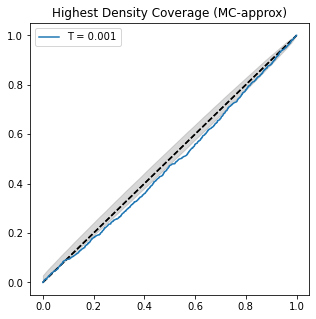

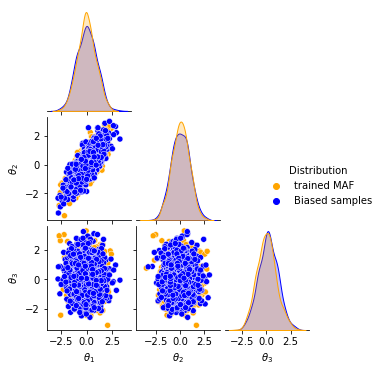

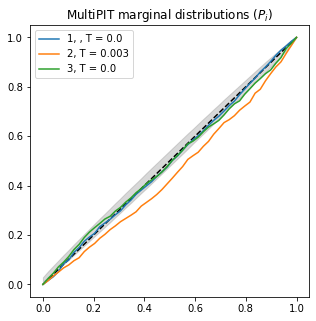

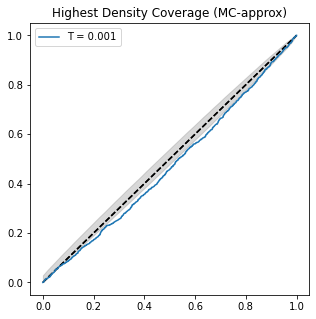

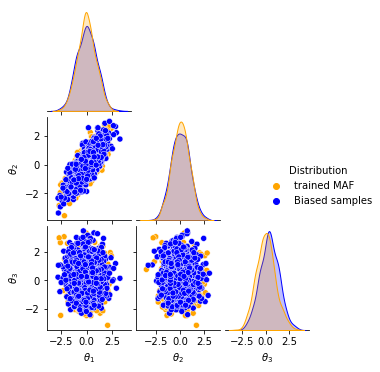

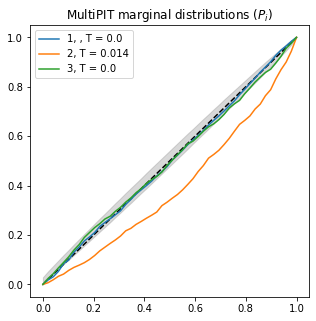

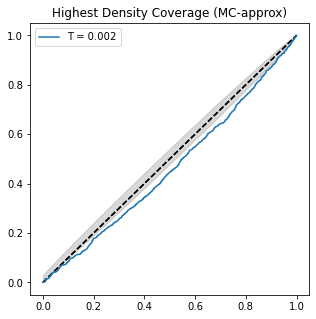

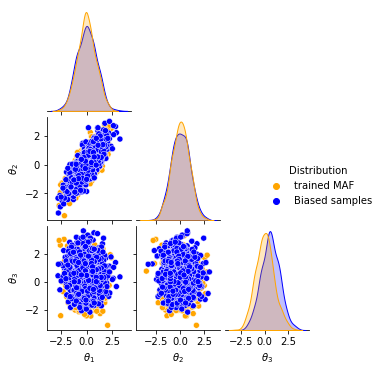

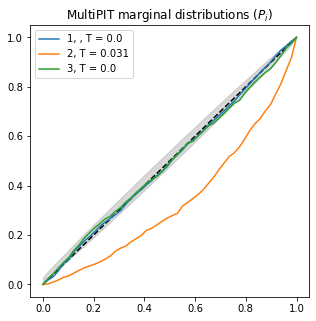

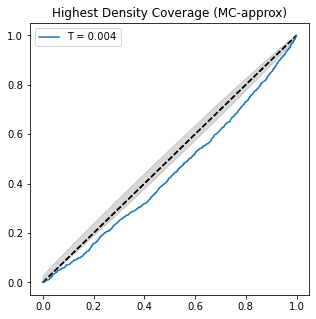

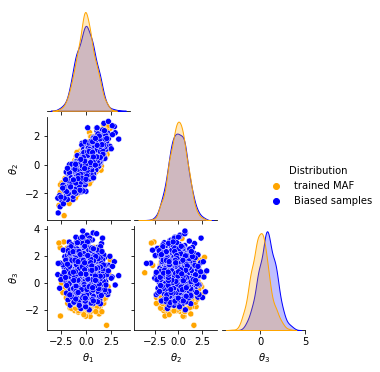

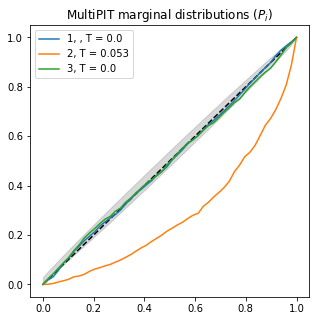

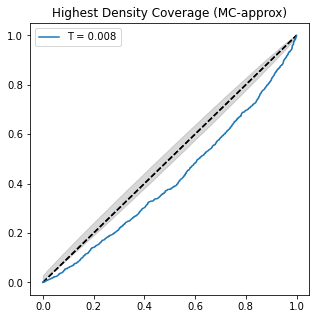

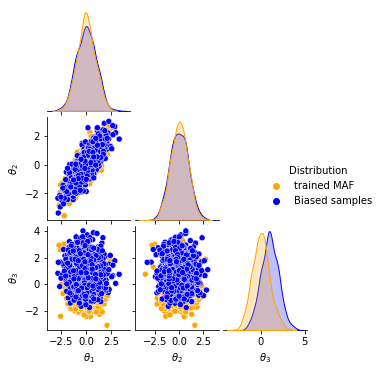

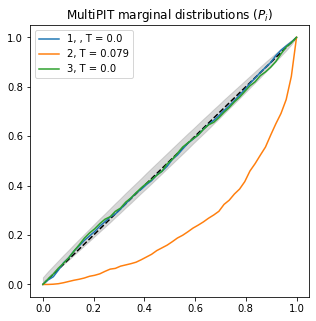

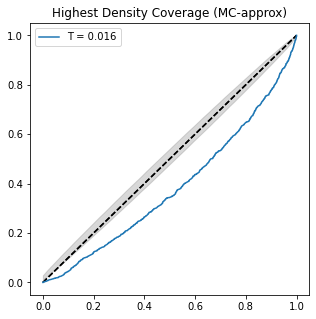

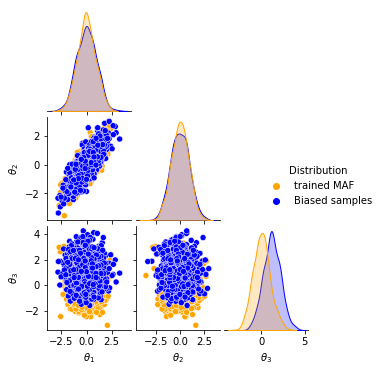

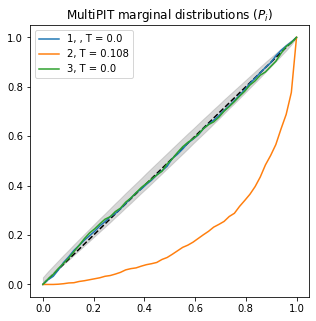

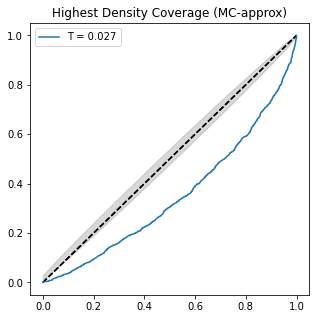

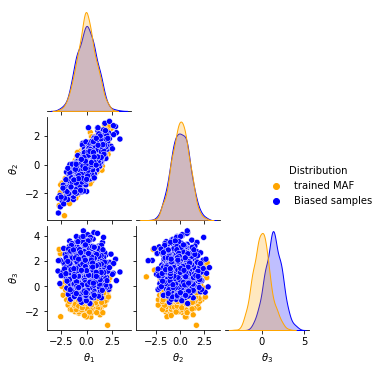

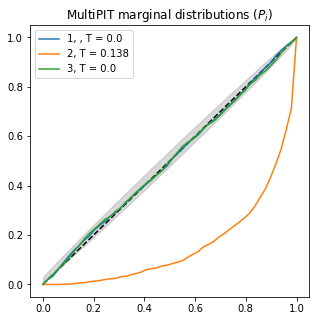

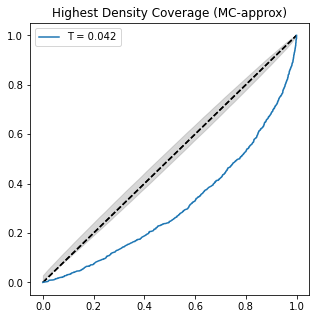

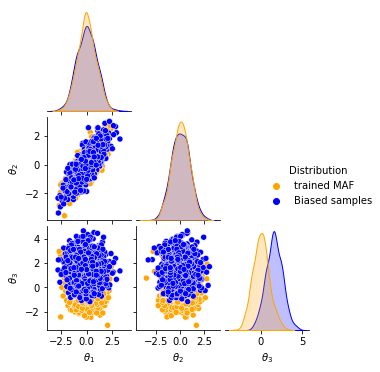

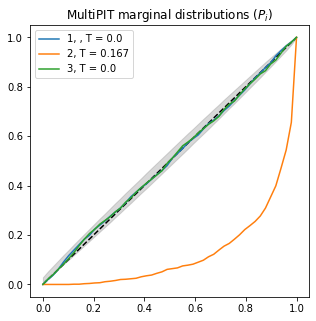

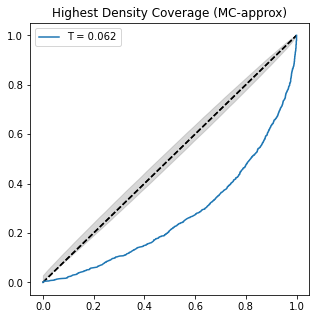

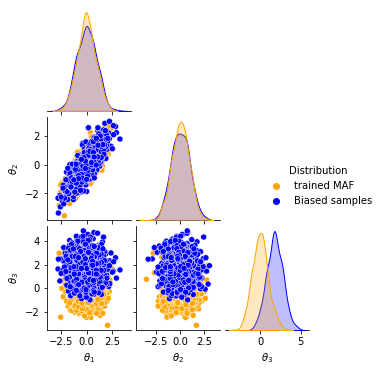

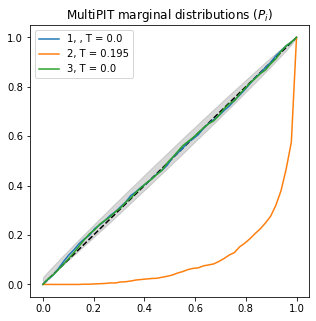

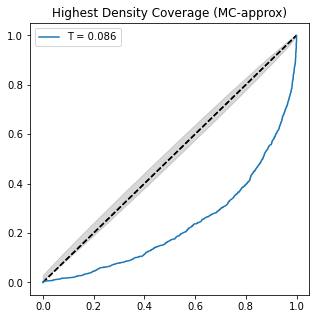

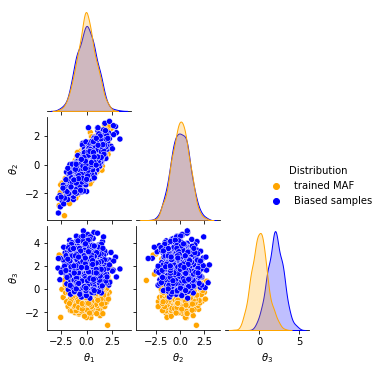

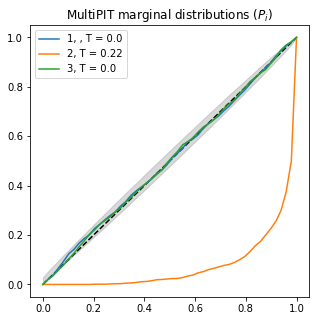

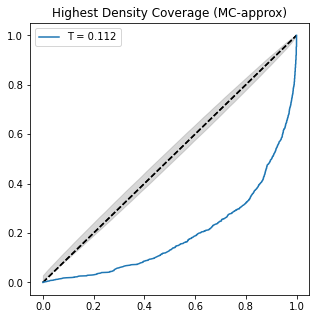

In [78]:
# Plot distribution and pp-plots of
# - the target distribution (here the false distribution) and
# - the learned maf (trained on the original data)

# Pairplot
columns = [r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]

maf_samples = maf.sample(test_size)
df_maf = pd.DataFrame(maf_samples.detach().numpy(), columns=columns)
df_maf["Distribution"] = "trained MAF"

test_statistics_multiPIT = {}
test_statistics_multiPIT['dim_1'] ={}
test_statistics_multiPIT['dim_2'] ={}
test_statistics_multiPIT['dim_3'] ={}
test_statistics_hdr = {}

bias = np.linspace(0,2,11)
for i,b in enumerate(bias):
    samples_false_test = np.array(datasets['test']).copy()
    samples_false_test[:,2] = samples_false_test[:,2] + b

    df_false = pd.DataFrame(samples_false_test, columns=columns)
    df_false["Distribution"] = "Biased samples"

    dfs = pd.concat([df_maf, df_false], ignore_index=True)

    g = sns.pairplot(dfs, hue="Distribution", corner=True, palette={"Biased samples":"blue", "trained MAF": "orange"})
    # g.fig.suptitle("rotation angle = "+str(thetas[i]))
    g.fig.set_size_inches(5,5)
    plt.show()

    samples_false_test = torch.FloatTensor(samples_false_test)

    # MAF transformation on false samples
    P_1_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 0].detach().numpy())  # 1D
    P_2_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 1].detach().numpy())  # 1D
    P_3_maf = norm.cdf(maf._transform(samples_false_test)[0][:, 2].detach().numpy())  # 1D

    # plot pp_plots variables 1,2,3
    alphas = np.linspace(0,1,50)
    confidence_region_null(alphas, conf_alpha=0.05/3)
    plt.plot(alphas,alphas, '--', color='black')

    z_maf_1 = [np.mean(P_1_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_1'][i] = np.round(((z_maf_1 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_1, label=f'1, , T = {test_statistics_multiPIT["dim_1"][i]}')
    z_maf_2 = [np.mean(P_2_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_2'][i] = np.round(((z_maf_2 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_2, label=f'2, T = {test_statistics_multiPIT["dim_2"][i]}')
    z_maf_3 = [np.mean(P_3_maf < alpha) for alpha in alphas]
    test_statistics_multiPIT['dim_3'][i] = np.round(((z_maf_3 - alphas) ** 2).sum() / len(alphas), 3)
    plt.plot(alphas, z_maf_3, label=f'3, T = {test_statistics_multiPIT["dim_3"][i]}')
    plt.legend()
    plt.title(r'MultiPIT marginal distributions ($P_i$)')
    plt.show()

    # HDP
    
    # t_ = torch.linspace(-10, 10, 100)
    # T1, T2, T3 = torch.meshgrid(t_, t_, t_)
    # samples = torch.cat([T1.reshape(-1, 1), T2.reshape(-1, 1), T3.reshape(-1, 1)], dim=1)

    # pdf = maf._log_prob(samples, context=None).exp()
    
    # # alphas = np.linspace(0.001,1,50)
    # coverage = []
    # for alpha in alphas:
    #     hdr_level = highest_density_level(pdf, alpha)
    #     c = np.array((torch.exp(maf.log_prob(samples_false_test)) > hdr_level)*1).mean()
    #     coverage.append(c)
    # test_statistics_hdr[i] = np.round(((coverage - alphas) ** 2).sum() / len(alphas), 3)

    confidence_region_null(alphas, conf_alpha = 0.05) 
    plt.plot(alphas,alphas, '--', color='black')
    
    # plt.plot(alphas, coverage, label=f'T = {test_statistics_hdr[i]}')
    # plt.title('Highest Density Coverage')
    # plt.legend()
    # plt.show()

    levels, coverages = highest_density(maf, samples_false_test)
    test_statistics_hdr[i] = np.round((((coverages - levels) ** 2).sum() / len(levels)).item(), 3)
    plt.plot(levels,levels, '--', color='black')
    plt.plot(levels, coverages, label=f'T = {test_statistics_hdr[i]}')
    plt.title('Highest Density Coverage (MC-approx)')
    plt.legend()
    plt.show()

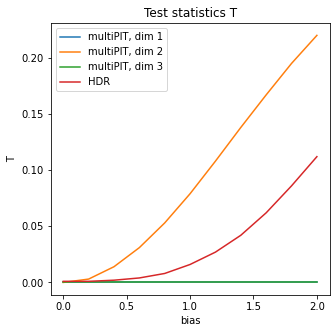

In [80]:
pd.Series(test_statistics_multiPIT['dim_1']).plot(label='multiPIT, dim 1')
pd.Series(test_statistics_multiPIT['dim_2']).plot(label='multiPIT, dim 2')
pd.Series(test_statistics_multiPIT['dim_3']).plot(label='multiPIT, dim 3')
pd.Series(test_statistics_hdr).plot(label='HDR')
plt.title('Test statistics T')
plt.legend()
plt.xlabel('bias')
plt.ylabel('T')
plt.xticks([0,2.5,5,7.5,10],np.linspace(0,2,5))
plt.show()

**Results:**
- HDR is less sensible than PIT (for small bias values)
- Again it does not inform us in which dimension(s) the bias occurs 
    
    --> but why is only dim 2 affected? 
    


Mutual independance of PIT for biased estimator

In [81]:
# true distribution
pit_eval_true = {
        'Z_1':maf._transform(datasets['test'])[0][:, 0].detach().numpy(),
        'Z_2':maf._transform(datasets['test'])[0][:, 1].detach().numpy(),
        'Z_3':maf._transform(datasets['test'])[0][:, 2].detach().numpy(),
    }
df_true = pd.DataFrame(pit_eval_true)
corr_12_true = df_true.corr()['Z_1'][1]
corr_23_true = df_true.corr()['Z_2'][2]
corr_13_true = df_true.corr()['Z_1'][2]
eig_vals_true = np.linalg.eig(df_true.cov())[0]
print(eig_vals_true)
df_true.corr()

[0.94051589 1.07675389 1.17137512]


,Z_1,Z_2,Z_3
Z_1,1.000000,-0.046838,0.011786
Z_2,-0.046838,1.000000,-0.028637
Z_3,0.011786,-0.028637,1.000000


In [83]:
# rotated samples (false distribution)
corr_12 = []
corr_23 = []
corr_13 = []
for k, b in enumerate(bias):
    samples_false = np.array(datasets['test']).copy()
    samples_false[:,2] = samples_false[:,2] + b
    samples_false = torch.FloatTensor(samples_false)
    pit_eval = {
        'P_1': maf._transform(samples_false)[0][:, 0].detach().numpy(),
        'P_2': maf._transform(samples_false)[0][:, 1].detach().numpy(),
        'P_3': maf._transform(samples_false)[0][:, 2].detach().numpy(),
    }
    df = pd.DataFrame(pit_eval)
    corr_12.append(df.corr()['P_1'][1])
    corr_23.append(df.corr()['P_2'][2])
    corr_13.append(df.corr()['P_1'][2])


In [84]:
# null hypothesis
from scipy.stats import norm

n_trials = 1000

corr_12_null = []
corr_23_null = []
corr_13_null = []
for t in range(n_trials):
    pit_eval_null = {
        'Z_1': norm().rvs(1000),
        'Z_2': norm().rvs(1000),
        'Z_3': norm().rvs(1000),
    }
    df_null = pd.DataFrame(pit_eval_null)
    corr_12_null.append(df_null.corr()['Z_1'][1])
    corr_23_null.append(df_null.corr()['Z_2'][2])
    corr_13_null.append(df_null.corr()['Z_1'][2])

df_null.corr()

,Z_1,Z_2,Z_3
Z_1,1.000000,-0.018131,-0.029189
Z_2,-0.018131,1.000000,0.007683
Z_3,-0.029189,0.007683,1.000000


#### Correlation Coeficient

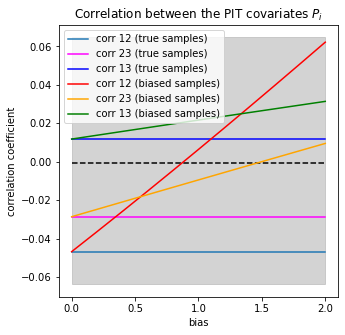

In [88]:
# PLOT
upp_lim = np.mean([np.quantile(corr_13_null, q=0.05/6), np.quantile(corr_12_null, q=0.05/2), np.quantile(corr_23_null, q=0.05/2)])
low_lim = np.mean([np.quantile(corr_13_null, q=1-0.05/6), np.quantile(corr_12_null, q=1-0.05/2), np.quantile(corr_23_null, q=1-0.05/2)])

mean = np.mean([np.mean(corr_13_null), np.mean(corr_12_null), np.mean(corr_23_null)])
plt.plot([mean]*len(bias), '--', color='black')
plt.fill_between(
        x=np.linspace(0, 10, len(bias)),
        y1=np.repeat(low_lim, len(bias)),
        y2=np.repeat(upp_lim, len(bias)),
        color="darkgrey",
        alpha=0.5,
    )

plt.plot([corr_12_true]*len(bias), label = 'corr 12 (true samples)')
plt.plot([corr_23_true]*len(bias), color = 'magenta', label = 'corr 23 (true samples)')
plt.plot([corr_13_true]*len(bias), color='blue', label='corr 13 (true samples)')
plt.plot(corr_12, label = 'corr 12 (biased samples)', color='red')
plt.plot(corr_23, label = 'corr 23 (biased samples)', color='orange')
plt.plot(corr_13, label = 'corr 13 (biased samples)', color='green')
plt.legend()
plt.xticks([0,2.5,5,7.5,10],np.linspace(0,2,5))
plt.xlabel('bias')
plt.ylabel('correlation coefficient')
plt.title(r'Correlation between the PIT covariates $P_i$')
plt.show()

## Pathological HPD case: iso-probability degeneracy
$$f(x, y)=(2\pi)^{−1}\exp[−(x^2+y^2)/2], \quad g(x, y)=\frac{1}{2\pi}\exp(−\frac{x^2+y^2}{2})[1+sin(\pi x)sin(\pi y)]$$

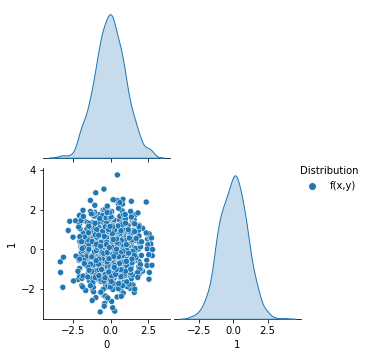

In [184]:
# True distribution: 2d unit gaussian (f)

# Parameters of the distribution
mu_1 = 0
mu_2 = 0
sigma_1 = 1
sigma_2 = 1
rho_12 = 0

mean = np.array([mu_1, mu_2])
covariance = np.array(
    [
        [sigma_1 ** 2, rho_12 * sigma_1 * sigma_2],
        [rho_12 * sigma_1 * sigma_2, sigma_2 ** 2],
    ]
)
f_dist = mvn(mean=mean, cov=covariance)
f_dist = uniform()

# Pairplot 
columns = [r"$x$", r"$y$"]
colors = ['blue', 'orange']
f_samples = f_dist.rvs(1000)
df_f = pd.DataFrame(f_samples)
df_f["Distribution"] = "f(x,y)"

# dfs = pd.concat([df_true, df_maf], ignore_index=True)

pair = sns.pairplot(df_f, hue="Distribution", corner=True)
pair.fig.set_size_inches(5,5)
plt.show()


In [345]:
def f(t):
    return 1/(2*np.pi) * np.exp(-(t[:,0]**2 + t[:,1]**2)/2)

def g(t):
    return 1/(2*np.pi) * np.exp(-(t[:,0]**2 + t[:,1]**2)/2) * (1+np.sin(t[:,0]*np.pi)*np.sin(t[:,1]*np.pi))

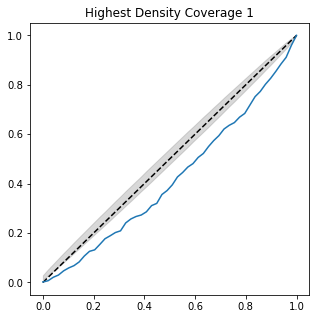

In [346]:
# Highest Density Coverage 1: 
# Plot the probability of a true sample to be in the alpha-hdr of the estimator q:
# P_{theta_0}(q(theta_0) > hdr_level(q,alpha))

t_ = torch.linspace(-5, 5, 100)
T1, T2 = torch.meshgrid(t_, t_)
samples = torch.cat([T1.reshape(-1, 1), T2.reshape(-1, 1)], dim=1)

pdf = g(samples)
alphas = np.linspace(0.0001,0.9999,50)
coverage = []
for alpha in alphas:
    hdr_level = highest_density_level(pdf, alpha)
    coverage.append(np.array((g(f_samples) > hdr_level)*1).mean())

confidence_region_null(alphas, conf_alpha=0.05)

plt.plot(alphas,alphas, '--', color='black')
plt.plot(alphas, coverage)
plt.title('Highest Density Coverage 1')
plt.show()